In [2]:
# Imports, mainly : numpy, pandas, sklearn, and matplotlib
import numpy as np
import os
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
directory = "../Data/train"
mean_heList = []
image_names = []
n_clusters = 2

In [4]:
# takes an image and returns its mean Hematox and Eosin values as a 2-tuple
def calculateMeanHE(image):
    hedImage = rgb2hed(image) # hed is short for Hematox, Eosin, DAB
    hemaValues = hedImage[:, :, 0]
    eosValues = hedImage[:, :, 1]
    return (hemaValues.mean(), eosValues.mean())

def calculateMeanRGB(image):
    pixels = image.load()
    width, height = image.size 
    num_pixels = width * height
    r_mean = g_mean = b_mean = 0 
    for i in range(width):
        for j in range(height): 
            r,g,b=pixels[i,j] 
            r_mean += r
            g_mean += g
            b_mean += b
    return [r_mean/num_pixels , g_mean/num_pixels , b_mean/num_pixels]

In [5]:
# loop through each image in directory and calculate its values
for filename in os.listdir(directory):
    if not filename.startswith('.') and '.tif' in filename:
        image = Image.open(os.path.join(directory, filename))
        image_names.append(filename)
        mean_heList.append(calculateMeanHE(image))
mean_heList

[(-0.5519284955050314, 0.17166868577590097),
 (-0.5218397378543245, 0.17918120051969674),
 (-0.5033175567921637, 0.21198899958845083),
 (-0.5047531837550352, 0.20794890954792156),
 (-0.504761635523075, 0.19032094612739106),
 (-0.5507732211117831, 0.18009588634626839),
 (-0.5562528133593427, 0.17735007795000837),
 (-0.523519990941979, 0.17577414415987316),
 (-0.5162046736005161, 0.18093289098398996),
 (-0.5519255452333325, 0.17782510679645633),
 (-0.49317414024671735, 0.17619899936391356),
 (-0.49399034503043665, 0.20105270602655076),
 (-0.4860235761503808, 0.2077407247365434),
 (-0.4878144372777365, 0.17172482227976166),
 (-0.5000086835160531, 0.1979459962357385),
 (-0.532785514540766, 0.19738483373929683),
 (-0.5352060837492707, 0.19007303404826079),
 (-0.5164755071999964, 0.1770861718774463),
 (-0.5461615550769303, 0.17843730635420788),
 (-0.5644984408805098, 0.16794778951934258),
 (-0.4828205030800236, 0.20789661690555528),
 (-0.5286023648481049, 0.17932684939254118),
 (-0.558863547

In [6]:
# Fit values into K-Means
meanHEMatrix = np.asarray(mean_heList)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(meanHEMatrix)

In [7]:
# make cluster directories first
# then make a symbolic link of every image in the corresponding cluster directory
for cluster in range(n_clusters): 
    os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

In [8]:
# Check if there is a new file
sub_directories = [str(cluster) for cluster in range(n_clusters)]
        
for i in range(len(image_names)):
    # if there isnt already a symlink of this image in the coressponding subdirectory, make one
    if image_names[i] not in os.listdir(directory + '/' + sub_directories[kmeans.labels_[i]]): 
        os.symlink('../' + directory + '/{}'.format(image_names[i]), 
                   directory + '/{}/{}'.format(kmeans.labels_[i],image_names[i]))

Text(0, 0.5, 'Eosin')

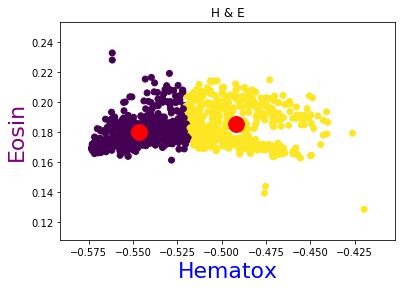

In [9]:
# LABEL_COLOR_MAP = {0 : 'b', 1 : 'm'} # blue is for hematox and magneta (purple) is for eosin

# label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

plt.scatter(meanHEMatrix[:,0], meanHEMatrix[:,1], c=kmeans.labels_) # column 0 is hematox, column 1 is Eosin

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, alpha=1);

plt.title('H & E')
plt.xlabel('Hematox',fontsize=22, color='blue')
plt.ylabel('Eosin',fontsize=22, color='purple')


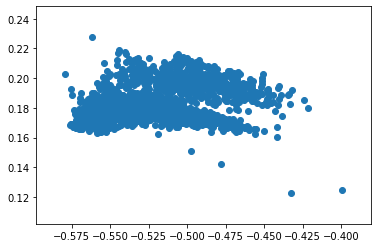

In [10]:
plt.scatter(meanHEMatrix[:,0], meanHEMatrix[:,1]) # column 0 is hematox, column 1 is Eosin

In [17]:
# true labels is a list of 0s and 1s (cancerous & non-cancerous)

csvFilePath = "../first1000.csv"
df = pd.read_csv(csvFilePath)
labels_true = []
labels_pred = kmeans.labels_

# Make sure the order of true labels and order of predicted labels match
for image in image_names:
    label_index = df[df["id"] == image.split(".")[0]].index[0]
    labels_true.append(df["label"][label_index])

evaluation = metrics.classification_report(labels_true, labels_pred)
print(evaluation)
# print(np.count_nonzero(kmeans.labels_ == 1) / (labels_true.count(1)) * 100)
# print(np.count_nonzero(kmeans.labels_ == 0) / (labels_true.count(0)) * 100)
# print(np.count_nonzero(kmeans.labels_ == 1))
# labels_true.count(1)
metrics.normalized_mutual_info_score(df["label"].values, kmeans.labels_)
# df["label"].values

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1176
           1       0.60      0.43      0.50       784

    accuracy                           0.66      1960
   macro avg       0.64      0.62      0.62      1960
weighted avg       0.65      0.66      0.64      1960



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.051903227932886674

In [12]:
# Evaluate them the other way
# InvertedKmeans = list(map(lambda x: abs(x-1), kmeans.labels_)) # flip 1s and 0s
# print(metrics.classification_report(labels_true, InvertedKmeans, target_names=target_names))

array([[-9.30187257e-01, -9.00623890e-01],
       [-2.46301419e-03, -2.49594290e-01],
       [ 5.68629904e-01,  2.59350806e+00],
       ...,
       [-8.76582419e-01, -3.70987536e-01],
       [ 4.57250502e-01, -4.04178768e-03],
       [-1.47905015e+00,  3.83248767e-01]])

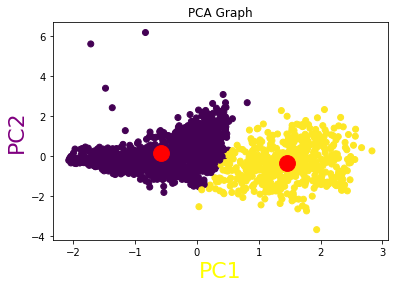

In [13]:
# Standardize the dataset by removing the mean and scaling to unit variance z =(x-u)/s
scaler = StandardScaler()
scaler.fit(meanHEMatrix)
scaledData = scaler.transform(meanHEMatrix)

# PCA 
pca = PCA(n_components=2)
pca.fit(scaledData)
transformedData = pca.transform(scaledData)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=0).fit(transformedData)

plt.scatter(transformedData[:,0], transformedData[:,1], c=kmeans.labels_)

# Show K-Means centers as red circles
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, alpha=1);

plt.title('PCA Graph')
plt.xlabel('PC1', fontsize=22, color='yellow')
plt.ylabel('PC2', fontsize=22, color='purple')

evaluation = metrics.classification_report(labels_true, kmeans.labels_)
# print(evaluation)
silhouette_avg = metrics.silhouette_score(meanHEMatrix, kmeans.labels_)
# print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
transformedData
scaledData

In [14]:
############ Correction evaluation

# make a mapping between file names and labels for evaluation of the correction of symlinks
mappingdict = {}
for i in range(len(image_names)):
    mappingdict[image_names[i]] = kmeans.labels_[i]
    
# check kmeans labels against symbolic links (subdirectory name)
def evaluteSymbLinks():
    for subdirectory in sub_directories:
        for image in os.listdir(directory + '/' + subdirectory):
            if str(mappingdict[image]) != subdirectory:
                print(f'{image} {subdirectory}')
                return False
    return True

# check kmeans labels against symbolic links (subdirectory name)
# By checking that they are in the same order
def evaluteImagesCorrespondance():
    mylist = df["id"].values == [image.split(".")[0] for image in image_names]
    if False in mylist:
        return False
    return True 
           
print(f'evaluted symbolic links to {evaluteSymbLinks()}')
print(f'evaluted Images coresspondance to {evaluteImagesCorrespondance()}')
sub_directories

f683eb1dbac270cdb404dbe67adecde6eb765c26.tif 0
evaluted symbolic links to False
evaluted Images coresspondance to True


['0', '1']

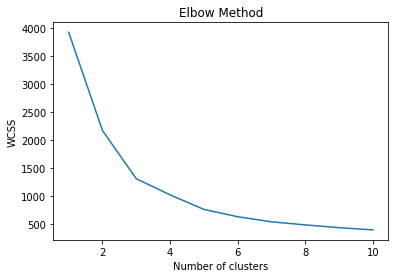

In [92]:
# Evaluate best number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(transformedData)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
# len(image_names)
len(os.listdir(directory))

1961